# Predict Average Bunker Score

Preidcts the average score for each bunker solely based on the sentiment analysis of the text in each review.

### 1. Imports

In [8]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


### 2: File paths

In [5]:
data_path = "../../data/processed/processed_bunker_sentiment.pkl"
model_path = "../outputs_final/bunker_multi_class/final_model"

### 3: Load and filter data

In [6]:
df = pd.read_pickle(data_path, )
bunker_counts = df["bunker_name"].value_counts()
valid_bunkers = bunker_counts[bunker_counts >= 100].index
df = df[df["bunker_name"].isin(valid_bunkers)].copy()
print(f"Filtered to {len(valid_bunkers)} bunkers with >= 100 reviews")

Filtered to 6 bunkers with >= 100 reviews


### 4: Load model and tokenizer

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # or "bert-base-cased"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Detect device: prioritize MPS, fallback to CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
print(f"Using device: {device}")

Using device: mps


### 5. Prediction function

In [10]:
def predict_sentiment_batch(token_batch):
    input_ids = torch.tensor([x["input_ids"] for x in token_batch]).to(device)
    attention_mask = torch.tensor([x["attention_mask"] for x in token_batch]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    return preds.cpu().tolist()


### 6: Predict in batches

In [6]:
batch_size = 32
tokens = df["tokens"].tolist()
predictions = []

for i in tqdm(range(0, len(tokens), batch_size)):
    batch = tokens[i:i+batch_size]
    preds = predict_sentiment_batch(batch)
    predictions.extend(preds)

100%|██████████| 435/435 [50:32<00:00,  6.97s/it]  


### 7. Add predictions to dataframe

In [14]:
df["predicted_label"] = predictions
label_to_score = {0: -1, 1: 0, 2: 1}
df["sentiment_score"] = df["predicted_label"].map(label_to_score)

# Save to pickle
df.to_pickle("df_with_sentiment.pkl")


NameError: name 'predictions' is not defined

In [47]:
import gc
del tokens, batch, preds, predictions  # Delete if still in memory
gc.collect()

9235

### 8. Aggregate scores per bunker

In [15]:
bunker_scores = df.groupby("bunker_name")["sentiment_score"].mean().reset_index()
bunker_scores = bunker_scores.sort_values(by="sentiment_score", ascending=False)
bunker_scores.head()

KeyError: 'Column not found: sentiment_score'

### 9: Save results

In [9]:
output_path = "../../data/processed/bunker_sentiment_ranking.csv"
bunker_scores.to_csv(output_path, index=False)
print(f"Saved bunker sentiment ranking to: {output_path}")

Saved bunker sentiment ranking to: ../../data/processed/bunker_sentiment_ranking.csv


In [15]:
import pandas as pd

# Load the full dataset
df = pd.read_pickle(data_path)

# Filter for years 2016 through 2024
df = df[df["year"].between(2016, 2024)]

# Count number of reviews per bunker
bunker_review_counts = (
    df["bunker_name"]
    .value_counts()
    .rename_axis("bunker_name")
    .reset_index(name="review_count")
    .sort_values(by="review_count", ascending=False)
)

# Show result
print(bunker_review_counts)


          bunker_name  review_count
0             hamburg          4710
1             betasom          3455
2            valentin          1694
3   larochelle_museum          1378
4           stnazaire          1317
5             keroman          1186
6            hornisse            88
7               fink2            54
8               dora1            45
9               dora2            18
10              bruno             6
11              elbe2             2


In [24]:
# Load the dataset
df = pd.read_pickle(data_path)

# Filter for Hamburg bunker
hamburg_df = df[df["bunker_name"].str.contains("Betasom", case=False, na=False)]

# Count number of reviews per year
reviews_per_year = (
    hamburg_df["year"]
    .value_counts()
    .sort_index()
    .rename_axis("year")
    .reset_index(name="review_count")
)

# Show result
print(reviews_per_year)


   year  review_count
0  2018            65
1  2019           211
2  2020            54
3  2021           425
4  2022           899
5  2023          1063
6  2024           738
7  2025            41


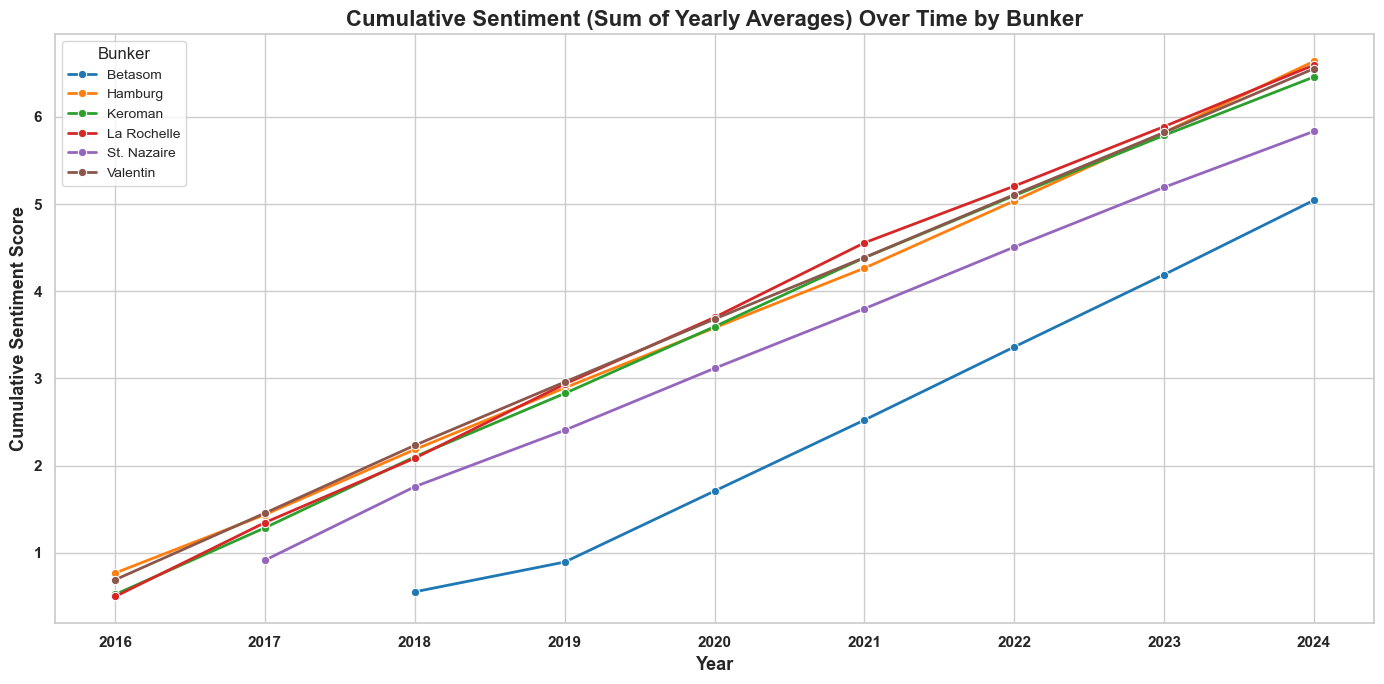

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for years 2016–2024
df = df[df["year"].between(2016, 2024)]

# Step 1: Group by bunker and year and compute average sentiment per year
yearly_avg = (
    df.groupby(["bunker_name", "year"])["sentiment_score"]
    .mean()
    .reset_index(name="avg_sentiment_per_year")
)

# Step 2: Sort and compute cumulative sum of yearly averages
yearly_avg = yearly_avg.sort_values(by=["bunker_name", "year"])
yearly_avg["cumulative_sentiment"] = yearly_avg.groupby("bunker_name")["avg_sentiment_per_year"].cumsum()

# Step 3: Apply formatted names
yearly_avg["bunker_name_formatted"] = yearly_avg["bunker_name"].replace({
    "stnazaire": "St. Nazaire",
    "larochelle_museum": "La Rochelle",
    "keroman": "Keroman",
    "betasom": "Betasom",
    "hamburg": "Hamburg",
    "valentin": "Valentin",
})

# Step 4: Plotting
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

ax = sns.lineplot(
    data=yearly_avg,
    x="year",
    y="cumulative_sentiment",
    hue="bunker_name_formatted",
    marker="o",
    linewidth=2,
    palette="tab10"
)

# Styling
plt.title("Cumulative Sentiment (Sum of Yearly Averages) Over Time by Bunker", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=13, fontweight="bold")
plt.ylabel("Cumulative Sentiment Score", fontsize=13, fontweight="bold")
plt.xticks(fontsize=11, fontweight="bold")
plt.yticks(fontsize=11, fontweight="bold")
plt.legend(title="Bunker", title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter to years 2016–2024
df = df[df["year"].between(2016, 2024)]

# Step 2: Count reviews by bunker and predicted label
sentiment_counts = (
    df.groupby(["bunker_name", "predicted_label"])
    .size()
    .unstack(fill_value=0)
)

# 🔧 Fix: Rename numeric columns to string labels
sentiment_counts.columns = sentiment_counts.columns.map({
    0: "negative",
    1: "neutral",
    2: "positive"
})

# Step 3: Convert to proportions (each row sums to 1)
sentiment_props = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Step 4: Rename bunkers (formatted names)
sentiment_props = sentiment_props.rename(index={
    "stnazaire": "St. Nazaire",
    "larochelle_museum": "La Rochelle",
    "keroman": "Keroman",
    "betasom": "Betasom",
    "hamburg": "Hamburg",
    "valentin": "Valentin",
})

# Step 5: Plotting
ax = sentiment_props.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    color={
        "negative": "#d62728",  # red
        "neutral": "#ff7f0e",   # orange
        "positive": "#2ca02c"   # green
    },
    edgecolor="black"
)

# Styling
plt.title("Sentiment Distribution by Bunker (2016–2024)", fontsize=16, fontweight="bold")
plt.xlabel("Bunker", fontsize=13, fontweight="bold")
plt.ylabel("Proportion of Reviews", fontsize=13, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Sentiment", title_fontsize=12, fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()


NameError: name 'df' is not defined